In [1]:
# 한국어 토크나이저중 mecab 사용을 위해 다운로드 
!pip install -q python-mecab-ko

In [2]:
import gc  # 가비지 컬렉터 인터페이스
import os  # 운영체제와 상호작용을 위한 모듈
import argparse  # 명령줄 인자 파싱을 위한 모듈
import pandas as pd  # 데이터 처리를 위한 라이브러리
from mecab import MeCab # 한국어 토크나이저 Mecab
from tqdm.auto import tqdm  # 진행률 표시를 위한 라이브러리
from datasets import Dataset  # Hugging Face의 데이터셋 라이브러리
from lightgbm import LGBMClassifier  # LightGBM 모델
from transformers import PreTrainedTokenizerFast  # Hugging Face의 사전훈련된 토크나이저
from sklearn.linear_model import SGDClassifier  # 확률적 경사 하강법 분류기
from sklearn.naive_bayes import MultinomialNB  # 다항 나이브 베이즈 분류기
from transformers import BertTokenizer, BertModel  # 한글 처리에 적합한 BERT 모델과 토크나이저
from sklearn.model_selection import train_test_split # test train split 9대1 비율로
from sklearn.feature_extraction.text import TfidfVectorizer  # 텍스트를 TF-IDF 특성으로 변환
from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, trainers  # 토크나이저

In [3]:
# 훈련 데이터 로드 (중복 제거 후)
all_df = pd.read_csv("/kaggle/input/translated-essaysko/train_drcat_02_translated.csv", sep=',')
all_df = all_df.drop_duplicates(subset=['text'])
all_df.reset_index(drop=True, inplace=True)

print(f"length : {len(all_df)}")
display(all_df.head())

length : 39689


,text,label,source,fold,essay_id,prompt,19
0,"친애하는 교장 선생님,\n\n스포츠에 관한 학교 정책을 바꾸는 것을 고려하고 있다고...",0,persuade_corpus,3,45A5FD941F4A,NaN,NaN
1,자동차 사용은 왜 세계에 대기 오염이 그렇게 많은지에 대한 가장 큰 이유 중 하나입...,0,persuade_corpus,5,B30188D7A074,NaN,NaN
2,"친애하는 교장 선생님,\n\n학생들에게 봉사활동을 시키는 것은 좋은 일이라고 생각합...",0,persuade_corpus,0,052F182ACD73,NaN,NaN
3,여름 프로젝트는 학생이 디자인한 것을 기반으로 해야 합니다. 학생들은 자신이 무엇을...,0,persuade_corpus,4,5402D8B83297,NaN,NaN
4,"딩딩딩 여름이 오기 전 마지막 종소리가 울리고, 학생들은 비명을 지르며 복도를 뛰어...",0,persuade_corpus,8,14D4B556B3A2,NaN,NaN


In [4]:
all_df = all_df[['text','label']]

# 훈련 데이터와 테스트 데이터로 나누기 (Stratified Sampling 사용)
train_df, test_df = train_test_split(all_df, test_size=0.1, stratify=all_df['label'], random_state=42)

# train_df = train_df[:25000]
print("훈련 데이터 길이:", len(train_df))
print("테스트 데이터 길이:", len(test_df))

훈련 데이터 길이: 35720
테스트 데이터 길이: 3969


In [5]:
mecab = MeCab()

# 토크나이저
def tokenizer_mecab(text):
    return mecab.morphs(text)

# 테스트와 훈련 데이터 토크나이징
print("test 데이터 토크나이징 시작...")
tokenized_texts_test = [tokenizer_mecab(text) for text in tqdm(test_df['text'].tolist())]

print("train 데이터 토크나이징 시작...")
tokenized_texts_train = [tokenizer_mecab(text) for text in tqdm(train_df['text'].tolist())]

test 데이터 토크나이징 시작...


  0%|          | 0/3969 [00:00<?, ?it/s]

train 데이터 토크나이징 시작...


  0%|          | 0/35720 [00:00<?, ?it/s]

In [6]:
# TF-IDF 벡터라이저 설정
def dummy(text):
    return text

vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, analyzer='word',
                             tokenizer=dummy, preprocessor=dummy,
                             token_pattern=None, strip_accents='unicode')
vectorizer.fit(tokenized_texts_test)  # 벡터라이저 학습

# 어휘 사전 가져오기
vocab = vectorizer.vocabulary_

# 어휘 사전을 사용하여 벡터라이저 재설정
vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, vocabulary=vocab,
                             analyzer='word', tokenizer=dummy, preprocessor=dummy,
                             token_pattern=None, strip_accents='unicode'
                             )

# TF-IDF 변환 수행
tf_train = vectorizer.fit_transform(tokenized_texts_train)
tf_test = vectorizer.transform(tokenized_texts_test)

# 메모리 정리
# del vocab, vectorizer, tokenized_texts_train, tokenized_texts_test
# gc.collect()

In [7]:
y_train = train_df['label'].values

# 모델 훈련
clf = MultinomialNB(alpha=0.02)
sgd_model = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber")
lgb = LGBMClassifier(**{
    'n_iter': 2500,
    'num_leaves': 51,
    'objective': 'cross_entropy',
    'metric': 'auc',
    'learning_rate': 0.05,
    'colsample_bytree': 0.726,
    'colsample_bynode': 0.5803,
    'lambda_l1': 8.5629,
    'num_threads': 4,
    'lambda_l2': 4.8932,
    'min_data_in_leaf': 115,
    'max_depth': 23,
    'max_bin': 898
})

clf.fit(tf_train, y_train)
sgd_model.fit(tf_train, y_train)
lgb.fit(tf_train, y_train)

# 모델 예측 및 앙상블
p1 = clf.predict_proba(tf_test)[:, 1]
p2 = sgd_model.predict_proba(tf_test)[:, 1]
p3 = lgb.predict_proba(tf_test)[:, 1]
final_preds = p1*0.1 + p2*0.45 + p3*0.45
test_df['generated'] = final_preds

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] lambda_l2 is set=4.8932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8932
[LightGBM] [Warning] lambda_l1 is set=8.5629, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.5629
[LightGBM] [Warning] num_iterations is set=2500, n_iter=2500 will be ignored. Current value: num_iterations=2500
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] lambda_l2 is set=4.8932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8932
[LightGBM] [Warning] lambda_l1 is set=8.5629, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.5629
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 20.634356 seconds.
You can 

ROC-AUC 면적: 0.9987549839401691


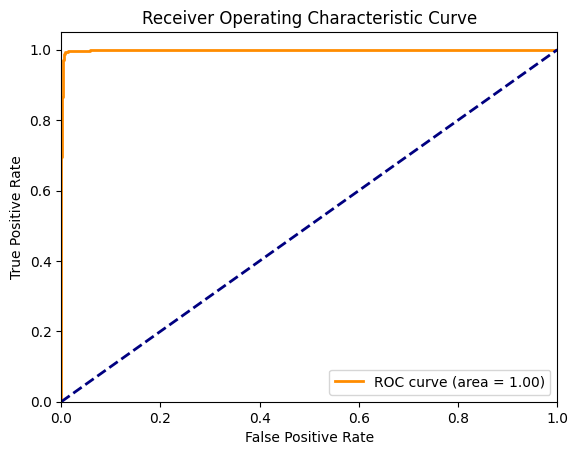

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 실제 라벨
y_true = test_df['label'].values

# ROC 곡선 그리기
fpr, tpr, thresholds = roc_curve(y_true, final_preds)
roc_auc = auc(fpr, tpr)

# ROC 곡선 시각화
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")

# ROC-AUC 면적 출력
print("ROC-AUC 면적:", roc_auc)

plt.show()

In [15]:
import pandas as pd

real_test_df = pd.read_csv('/kaggle/input/korean-essay/korean_essay.csv')

real_test_df = real_test_df[['생성 Text', 'model']]
real_test_df['label'] = real_test_df['model'].apply(lambda x: 1 if 'gpt' in str(x).lower() else 0)
real_test_df = real_test_df[['생성 Text','label']]
before = len(real_test_df)
real_test_df =real_test_df.dropna(axis=0).reset_index(drop=True)
after = len(real_test_df)

print(f'nan 값 제거 {before} -> {after}')
display(real_test_df.head(20))

print("real test 데이터 토크나이징 시작...")
tokenized_texts_real_test = [tokenizer_mecab(text) for text in tqdm(real_test_df['생성 Text'].tolist())]
print('벡터 변환중..')
real_tf_test = vectorizer.transform(tokenized_texts_real_test)

/tmp/ipykernel_33/2423392989.py:3: DtypeWarning: Columns (0,1,2,3,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  real_test_df = pd.read_csv('/kaggle/input/korean-essay/korean_essay.csv')


nan 값 제거 1048570 -> 501


,생성 Text,label
0,\n제시문 (가)는 역사적으로 새로운 종교를 창설하려는 시도가 실패로 끝났음에도 불...,1
1,제시문 가-2에서는 돈 키호테와 산초의 대화를 통해 현실과 환상 사이의 갈등이 나타...,1
2,"주제어로 선택된 공통 키워드는 ""아름다움""입니다.\n\n제시문 (가)에서는 매화의 ...",1
3,네 제시문들의 순서를 정하기 위해서는 각 제시문이 개인과 사회 간 영향을 어떻게 다...,1
4,네 제시문들에는 현대 사회에서의 갈등 상황에 대한 다양한 해법과 접근 방식이 내포되...,1
5,아킬레우스가 뤼카온에 대해 보이는 태도의 가장 두드러진 특징은 '냉혹함'입니다. 아...,1
6,"\n""공감""은 다른 이의 감정, 상황, 경험을 이해하고 공유하는 것을 의미합니다. ...",1
7,"인간과 동물 간의 관계에 대한 제시문 (가), (나), (다)는 각각 다른 시각에서...",1
8,제시문 <가>와 <나>에서는 글쓰기와 지식 발전의 관계에 대해 다양한 관점을 제시하...,1
9,제시문 <나>에서는 글쓰기와 글 읽기의 중요성을 강조하고 있습니다. 글쓰기와 글 읽...,1


real test 데이터 토크나이징 시작...


  0%|          | 0/501 [00:00<?, ?it/s]

벡터 변환중..


In [17]:
# 모델 예측 및 앙상블
real_p1 = clf.predict_proba(real_tf_test)[:, 1]
real_p2 = sgd_model.predict_proba(real_tf_test)[:, 1]
real_p3 = lgb.predict_proba(real_tf_test)[:, 1]
real_final_preds = real_p1*0.1 + real_p2*0.45 + real_p3*0.45
real_test_df['generated'] = real_final_preds
real_test_df.head(20)

[LightGBM] [Warning] lambda_l2 is set=4.8932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8932
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] lambda_l1 is set=8.5629, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.5629


,생성 Text,label,generated
0,\n제시문 (가)는 역사적으로 새로운 종교를 창설하려는 시도가 실패로 끝났음에도 불...,1,0.784599
1,제시문 가-2에서는 돈 키호테와 산초의 대화를 통해 현실과 환상 사이의 갈등이 나타...,1,0.656423
2,"주제어로 선택된 공통 키워드는 ""아름다움""입니다.\n\n제시문 (가)에서는 매화의 ...",1,0.625514
3,네 제시문들의 순서를 정하기 위해서는 각 제시문이 개인과 사회 간 영향을 어떻게 다...,1,0.648654
4,네 제시문들에는 현대 사회에서의 갈등 상황에 대한 다양한 해법과 접근 방식이 내포되...,1,0.886805
5,아킬레우스가 뤼카온에 대해 보이는 태도의 가장 두드러진 특징은 '냉혹함'입니다. 아...,1,0.430047
6,"\n""공감""은 다른 이의 감정, 상황, 경험을 이해하고 공유하는 것을 의미합니다. ...",1,0.749927
7,"인간과 동물 간의 관계에 대한 제시문 (가), (나), (다)는 각각 다른 시각에서...",1,0.789418
8,제시문 <가>와 <나>에서는 글쓰기와 지식 발전의 관계에 대해 다양한 관점을 제시하...,1,0.864041
9,제시문 <나>에서는 글쓰기와 글 읽기의 중요성을 강조하고 있습니다. 글쓰기와 글 읽...,1,0.920209


ROC-AUC 면적: 0.9066878306878305


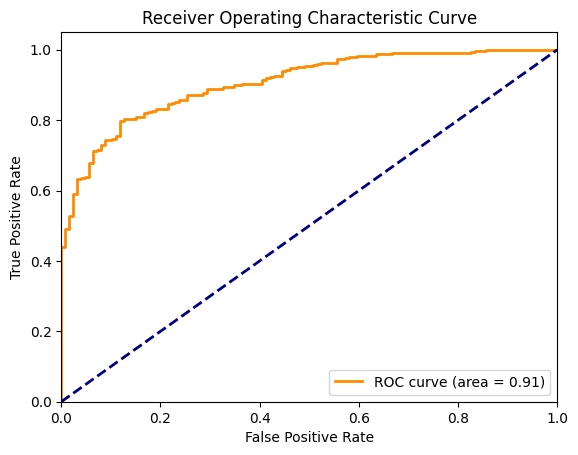

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 실제 라벨
y_true = real_test_df['label'].values

# ROC 곡선 그리기
fpr, tpr, thresholds = roc_curve(y_true, real_final_preds)
roc_auc = auc(fpr, tpr)

# ROC 곡선 시각화
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")

# ROC-AUC 면적 출력
print("ROC-AUC 면적:", roc_auc)

plt.show()

In [19]:
from sklearn.metrics import f1_score

# F1 스코어 계산
y_pred = [1 if score > 0.5 else 0 for score in real_final_preds]  # fixed_results는 모델 예측 결과로 가정
f1 = f1_score(y_true, y_pred)

# F1 스코어 출력
print("F1 Score:", f1)

F1 Score: 0.8871391076115485


In [20]:
real_test_df.to_csv('ghost_bursting.csv',index=False)